In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
sys.path.append('/home/chenani/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as pl
import numpy as np
import pickle as pkl
import Recordings
import signale, trajectory
import os
from scipy.signal import argrelextrema
from scipy.signal import gaussian
from scipy.stats import pearsonr
from scipy.stats import binom_test
import seaborn as sns
import itertools as it

/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
sns.set_style("white",{ 'legend.frameon': True})
colors = ['#FF0000', '#0000FF', '#008000', '#00FFFF', '#FF00FF', '#EE82EE',
        '#808000', '#800080', '#FF6347', '#FFFF00', '#9ACD32', '#4B0082',
        '#FFFACD', '#C0C0C0', '#A0522D', '#FA8072', '#FFEFD5', '#E6E6FA',
        '#F1FAC1', '#C5C5C5', '#A152ED', '#FADD72', '#F0EFD0', '#EEE6FF',
        '#01FAC1', '#F5F5F5', '#A152FF', '#FAFD72', '#F0EFDF', '#EEEFFF',
        '#F1FA99', '#C9C9C9', '#A152DD', '#FA5572', '#FFFFD0', '#EDD6FF']

In [4]:
def subsequence(sub,ref):
    '''
    A function to determine the number of specefic sequence repeated within a larger sequence.
    
    Parameters:
    sub:
    ref:
    
    
    Returns:
    idx : This an array containing the index of elements of sub in the ref! if idx is stricktly increasing the sequence sub
    is replayed whithin sequence ref!
    '''
    ref = np.array(ref)
    idx = np.array([])
    for ii in range(len(sub)):
        index = np.where(ref == sub[ii])[0]
        if index.size:
            idx = np.append(idx,index)
    idx = np.int0(idx)
    if idx.size:
        return idx, True
    else: 
        return [] , False
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
        supplied root directory.
    '''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield [path,filename]
def findClosestPoint(values,array):
    values = np.array(values)
    array = np.array(array)
    idx = np.array([np.square(array - value).argmin() for value in values])
    return idx,array[idx]
def coincidence(spikes):
    spikes.burstDetector()
    spikes.MuaDetector()
    mua = spikes.MultiUnitFiring
    ccdc = []
    for k in range(len(spikes)):
        for i in range(spikes[k].spike_times.size):
            less = np.where(mua[:, 0] < spikes[k].spike_times[i])[0]  # Ripples started before spike!    
            more = np.where(mua[:, 1] > spikes[k].spike_times[i])[0]  # Ripples ended after spike!
            mua_idx = np.intersect1d(less, more)  # index of the ripple covering the spike!
            if mua_idx.size:
                ccdc.append([k, i, mua_idx])
    ccdc = np.array(ccdc)
    ccdc = ccdc[np.argsort(ccdc[:, 2])]  # sorting w.r.t ripple index  
    spikes.overlap = ccdc
def MUA(spikes):

        if not hasattr(spikes, 'overlap'):
            print 'There is no overlap detected between spikes and ripples, calculating using default arguments...'
            spikes.coincidence()
        mua = []  # Multi Unit Activity
        bursts = []  # This keeps the firing activity(>=2spikes) during ripples
        repetition = []  # Contains the number of spikes in each ripple!
        ripp_set = set(spikes.overlap[:, 2])  # Keeps the tags of ripples containing MUA! 
        
        for item in ripp_set:
            repetition.append([item, np.where(spikes.overlap[:, 2] == item)[0].size])
        repetition = np.array(repetition)
        spikes.rippleSpikeContent = repetition
        
        for item in repetition[:, 0]:
            activity_block = spikes.overlap[np.where(spikes.overlap[:, 2] == item)]
            if not activity_block[:, 0].mean() == activity_block[0, 0]:
                mua.append(activity_block)
        spikes.MultiUnitActivity = mua
def sequencing(spikes):
        '''
        This function sequences the events detected by MUA() function
        
        Parameters
        ----------
        Returns
        ----------
        sequence_1st_spike : 
        sequence_median :
        
        See also
        ----------
        coincidence, MUA
        
        Notes
        ----------
         It takes the result of MUA function as input.
        '''
        fst_spk_sq = []
        median_sq = []  # Sequences based on first spike times!
        for item in spikes.MultiUnitActivity:
            cells = set(item[:, 0])
            sequence = []
            for jtem in cells:
                row_idx = np.where(item[:, 0] == jtem)[0]
                spk_times = spikes[jtem].spike_times[item[row_idx, 1]]  # This returns the spike times of a specific cell.
                sequence.append([jtem, spk_times.min(), np.median(spk_times), spk_times.size, item[0, 2]]) #No use for the last 2! Why did i put them there?
            sequence = np.array(sequence)
            sequence = sequence[np.argsort(sequence[:, 1])]
            fst_spk_sq.append(sequence)
            sequence = sequence[np.argsort(sequence[:, 2])]
            median_sq.append(sequence)
        spikes.sequence_1st_spike = fst_spk_sq
        spikes.sequence_median = median_sq

In [13]:
animalPath = '/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3906/LinearTrack_05-31-16_Day1/parrentData/'
placeCellList = animalPath + 'placeCells.spk'
trajectory = animalPath + 'linearTrack_Trajectory.traj'
dataFolder = '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/control/Rat3906Control/dataFiles/'

In [16]:
####Day1
leftFields  = pkl.load(open(dataFolder+'LtemplateD1.nparr'))
rightFields = pkl.load(open(dataFolder+'RtemplateD1.nparr'))

In [25]:
traj

In [28]:
pllSpikeTrain = pkl.load(open(placeCellList,'rb'))
pllSpikeTrain.changeTimeUnit('ms')
traj = pkl.load(open(trajectory,'rb'))
LTrain = pllSpikeTrain.time_slice(traj.t_start*1e3 ,traj.t_stop*1e3)
del pllSpikeTrain
animal = 'rat3906'

(4500, 4600)

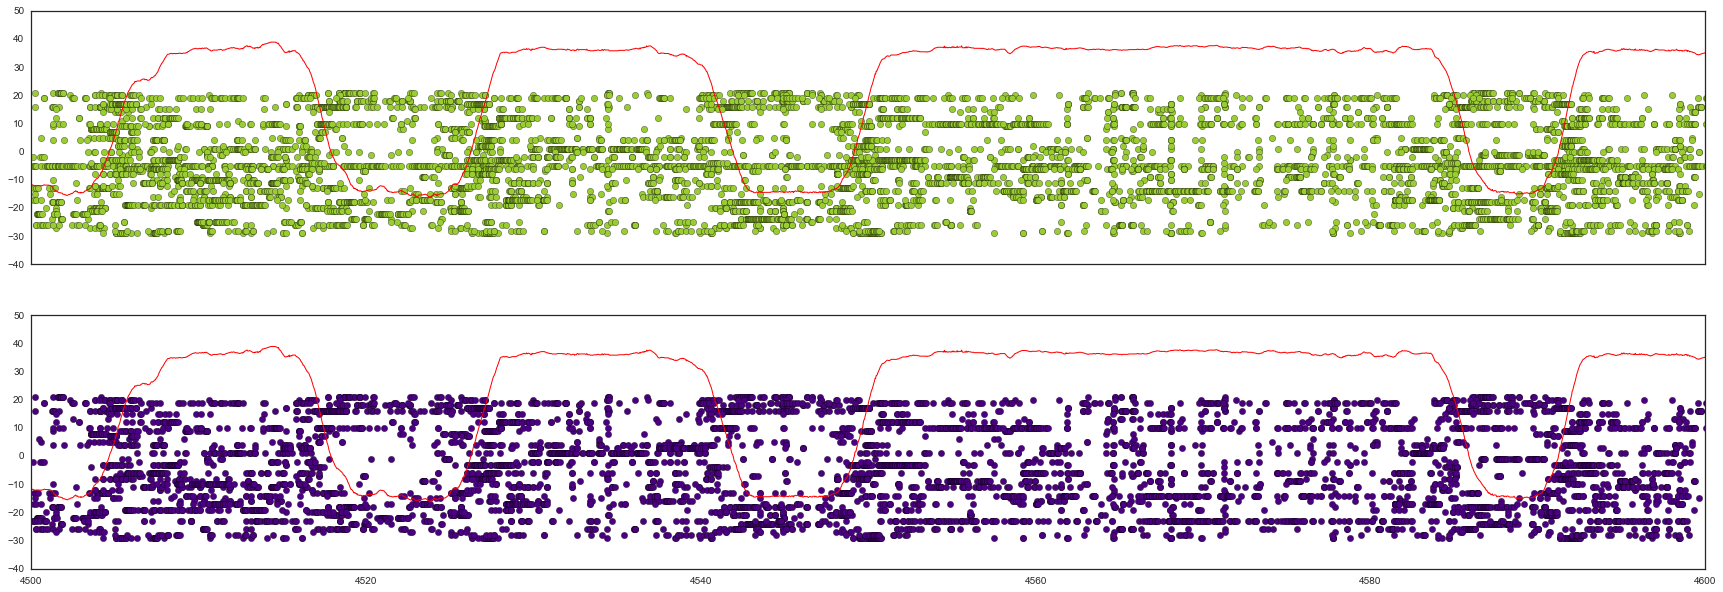

In [35]:
LTrain.changeTimeUnit('s')
f,ax = pl.subplots(2,1,sharex=True,figsize=[30,10])
for ii,item in enumerate(rightFields):
    spk = LTrain[item]
    ax[0].scatter(spk.spike_times,np.ones(spk.spike_times.size)*(21-item),c=colors[10],s=40)
xpoints = 28*traj.places[100:,0] - np.ones(traj.places.shape[0]-100)*17
ax[0].plot(traj.times[100:],xpoints,'r',lw=1)
for ii,item in enumerate(leftFields):
    spk = LTrain[item]
    ax[1].scatter(spk.spike_times,np.ones(spk.spike_times.size)*(21-item),c=colors[11],s=40)
xpoints = 28*traj.places[100:,0] - np.ones(traj.places.shape[0]-100)*17
ax[1].plot(traj.times[100:],xpoints,'r',lw=1)
ax[0].set_xlim(4500,4600)

In [36]:
#Interpolating trajectory
t = traj.times
It = np.arange(0,traj.times.size)
Itp = np.arange(0,traj.times.size,0.15)
tInterp = np.interp(Itp,It,t) #interpolated traj times
x = traj.places[:,0]
xp = np.interp(tInterp,t,x)       #interpolated traj Xposition
lapsDB = pkl.load(open(dataFolder+'/trajectory/linearTrackD1.db','rb'))
for zaehler, st in enumerate(LTrain):
    st.traj = traj
    st.getSpikePlaces();
    st.getRunningSpikes();

NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using 

In [37]:
LTrain.changeTimeUnit('ms')
tV,speed = traj.getSpeed()
stationary = np.where(speed < 0.1)[0]
takeoffs = tV[np.where(np.diff(stationary)>70)[0]]
takeoffs.size

122

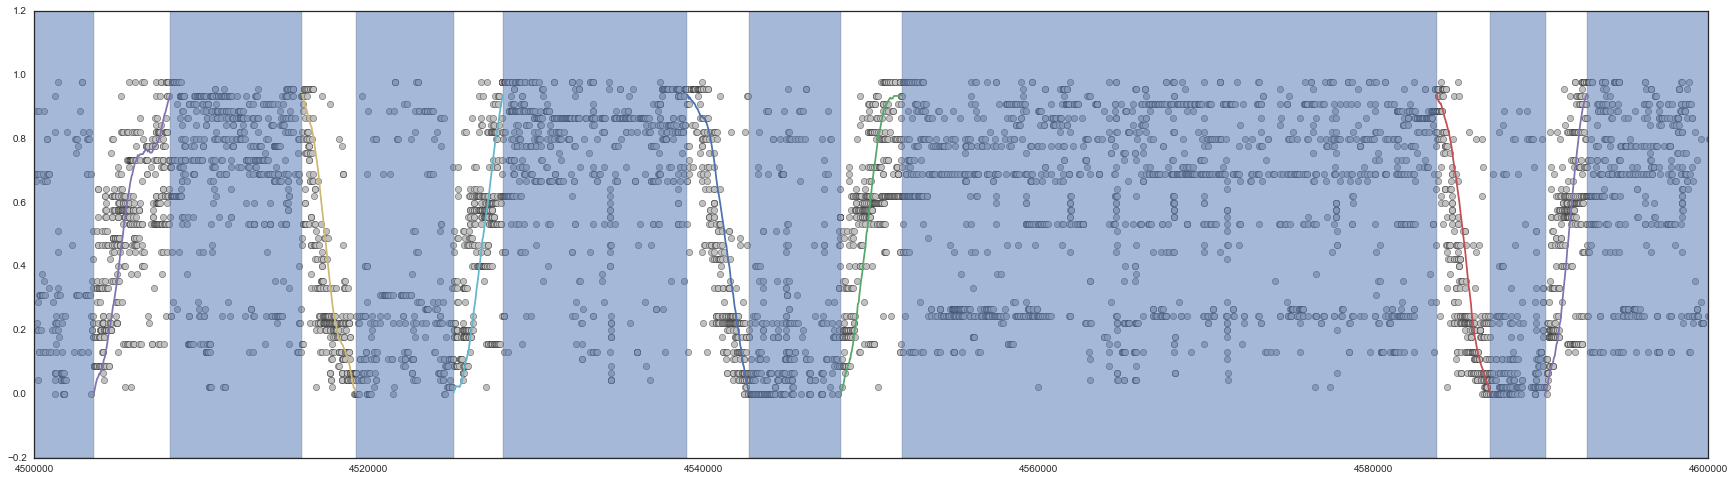

In [48]:
f,ax = pl.subplots(1,1,figsize=[30,8])
restPeriods = []
for ii,lap in enumerate(lapsDB):
    lapT = tInterp[lap[0]:lap[1]]*1e3
    lapX = xp[lap[0]:lap[1]]
    ax.plot(lapT,(lapX - np.ones(lapX.size)*0.15)/1.8)
    if ii <= 144:
        if np.abs(tInterp[lap[1]]-tInterp[lapsDB[ii+1][0]]) < 35:
            #print (tInterp[lap[1]]-tInterp[lapsDB[ii+1][0]])
            ax.axvspan(tInterp[lap[1]]*1e3,tInterp[lapsDB[ii+1][0]]*1e3,alpha=0.5)
            restPeriods.append([tInterp[lap[1]]*1e3,tInterp[lapsDB[ii+1][0]]*1e3])
    #for item in takeoffs[::-10]:
    #    ax[0].axvline(item*1e3)
for ii,item in enumerate(leftFields):
    spk = LTrain[item]
    ax.scatter(spk.spike_times,np.ones(spk.spike_times.size)*(float(ii)/leftFields.size),c=colors[13],s=40)
ax.set_xlim(4.5e6,4.6e6)
restPeriods = np.array(restPeriods)

In [49]:
LTrain.changeTimeUnit('ms')
LTrain.binwidth = 1
LTrain.calcTimeAxis()
hst = []
for unit in LTrain:
    hst.append(np.histogram(unit.spike_times,LTrain.timeAxis)[0])
hst = np.array(hst)
unitSum = hst.sum(axis=0)

(4500000.0, 4600000.0)

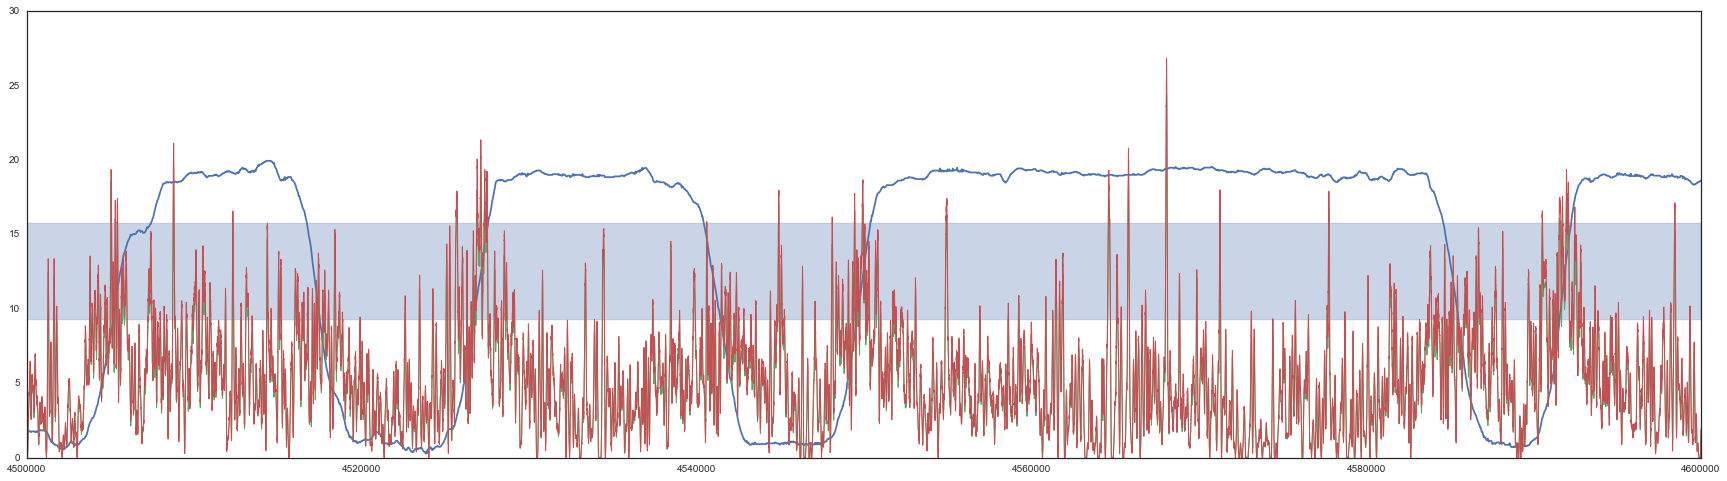

In [52]:
f,ax = pl.subplots(1,1,figsize=[30,8])
K1 = gaussian(200,25)
K2 = gaussian(100,30)
MUA1 = np.convolve(unitSum,K1,'same')
MUA2 = np.convolve(unitSum,K2,'same')
ax.plot(traj.times*1e3,10*traj.places[:,0])
ax.plot(LTrain.timeAxis[:-1],MUA1,lw=1)
ax.plot(LTrain.timeAxis[:-1],MUA2,lw=1)
ax.axhspan(MUA2.mean()+MUA1.std(),MUA2.mean()+3*MUA1.std(),alpha = 0.3)
ax.set_xlim(4.5e6,4.6e6)

In [53]:
canEv = []
peakTimes = []
for ii,rp in enumerate(restPeriods):
    validIdx = np.intersect1d(np.where(LTrain.timeAxis > rp[0])[0],np.where(LTrain.timeAxis < rp[1])[0])
    restMUA = MUA1[validIdx]
    restTimeAxis = LTrain.timeAxis[validIdx]
    m3sd = restMUA.mean() + 3*restMUA.std()
    msd = restMUA.mean() + restMUA.std()
    peaksIdx = argrelextrema(restMUA, np.greater)[0] #Peaks in MUA of selected rest.
    SigPeaksIndex = np.where(restMUA[peaksIdx] > 0.81*m3sd)[0]
    peakTimes.extend(restTimeAxis[peaksIdx][SigPeaksIndex])
#pl.plot(LTrain.timeAxis[:-1],MUA2)
print SigPeaksIndex

[6 9]


In [54]:
#peakTimes,restPeriods#,peakTimes.size

In [55]:
peakTimes = np.array(peakTimes)
closePeaksIdx = np.where(np.diff(peakTimes) < 200)[0]
peakTimes = np.delete(peakTimes,closePeaksIdx)

(4500000.0, 4600000.0)

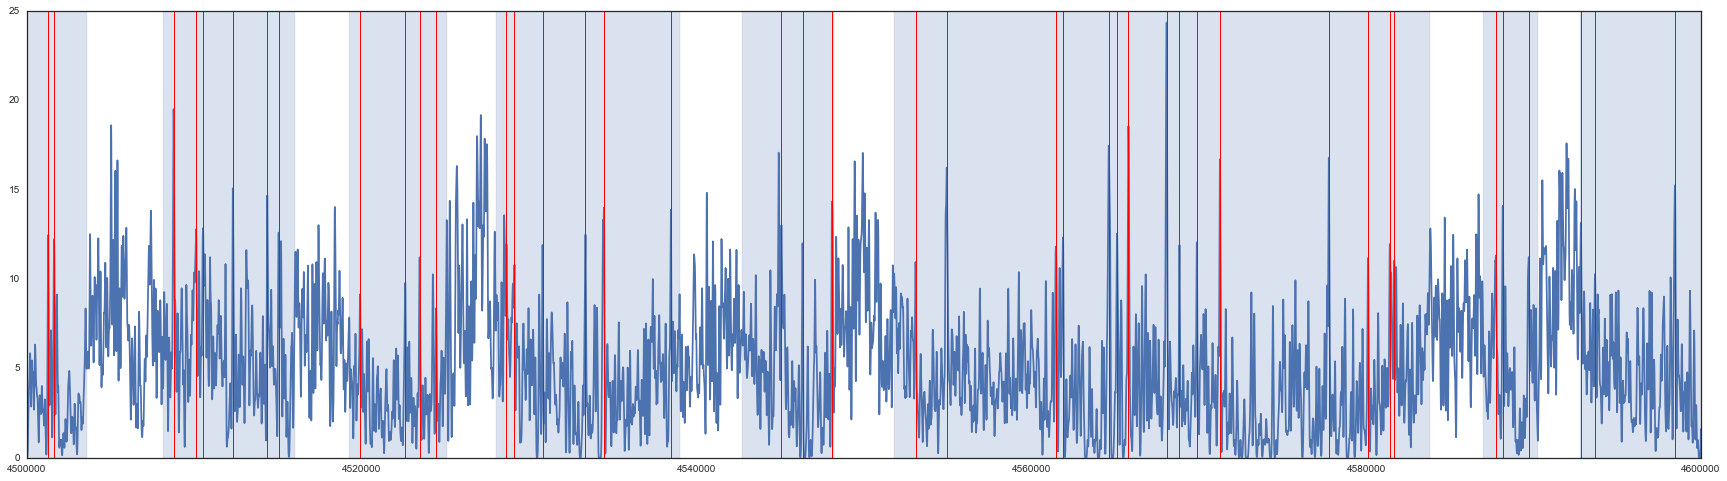

In [57]:
f,ax = pl.subplots(1,1,figsize=[30,8])
ax.plot(LTrain.timeAxis[:-1],MUA1)
for item in restPeriods:
    pl.axvspan(item[0],item[1],alpha=0.2)
for item in peakTimes:
    pl.axvline(item,linewidth=1,color='r')
ax.set_xlim(4.5e6,4.6e6)


(4500000.0, 4600000.0)

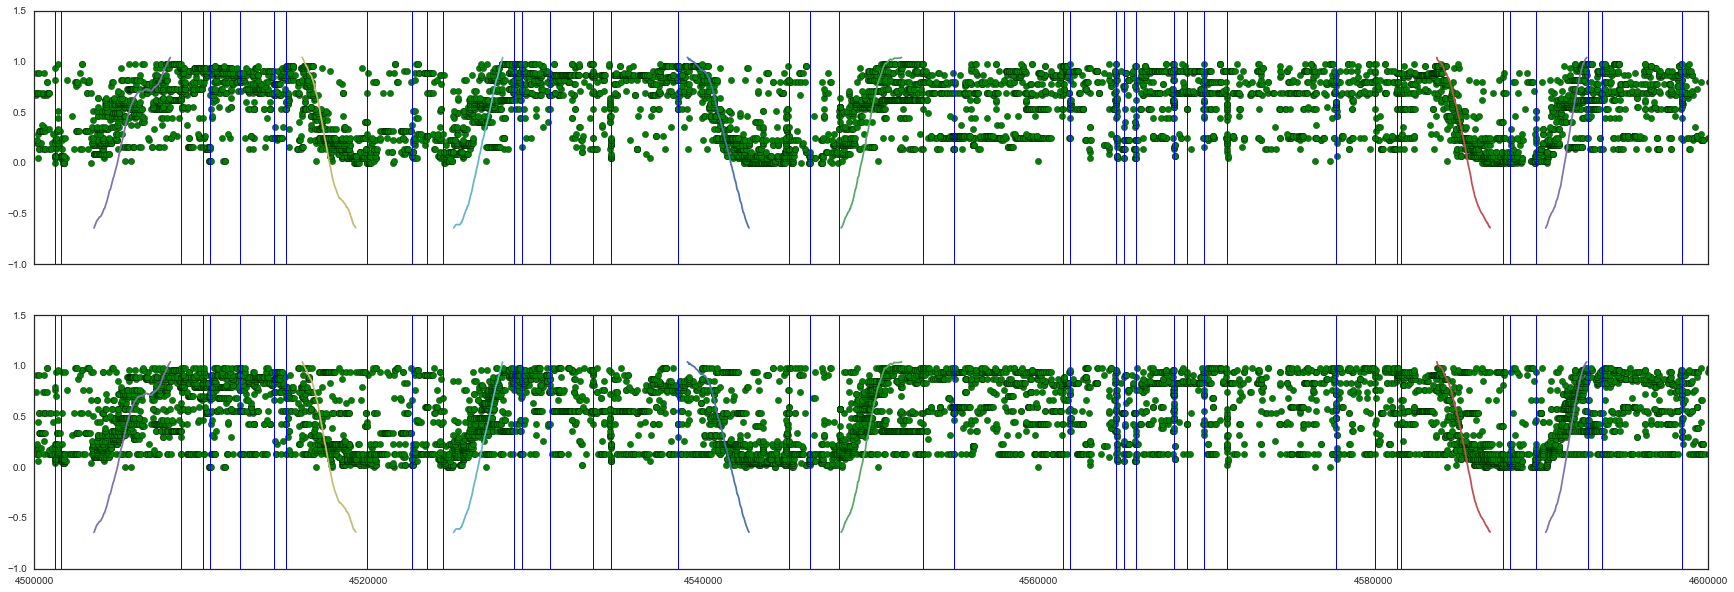

In [59]:
f,ax = pl.subplots(2,1,sharex=True,figsize=[30,10])
restPeriods = []
for ii,lap in enumerate(lapsDB):
    lapT = tInterp[lap[0]:lap[1]]*1e3
    lapX = xp[lap[0]:lap[1]]
    ax[0].plot(lapT,lapX - np.ones(lapX.size)*0.8)
    ax[1].plot(lapT,lapX - np.ones(lapX.size)*0.8)
for tt in peakTimes:
    ax[0].axvline(tt,linewidth=1)
    ax[1].axvline(tt,linewidth=1)
for ii,item in enumerate(leftFields):
    spk = LTrain[item]
    ax[0].scatter(spk.spike_times,np.ones(spk.spike_times.size)*(float(ii)/leftFields.size),c=colors[2],s=40)
for ii,item in enumerate(rightFields):
    spk = LTrain[item]
    ax[1].scatter(spk.spike_times,np.ones(spk.spike_times.size)*(float(ii)/rightFields.size),c=colors[2],s=40)
ax[0].set_xlim(4.5e6,4.6e6)


In [60]:
MUApeaks = []
for tP in peakTimes:
    Ncells = 0
    idx = np.where(LTrain.timeAxis == tP)[0][0]
    ii = idx-150
    jj = idx+150
    ti = LTrain.timeAxis[ii]
    tf = LTrain.timeAxis[jj]
    for spk in LTrain:
        inWindowSpikes = np.logical_and(spk.spike_times > ti,spk.spike_times < tf)
        if inWindowSpikes.sum():
            Ncells +=1
    if Ncells > 4:
        MUApeaks.append(tP)
MUApeaks = np.array(MUApeaks)

/home/chenani/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


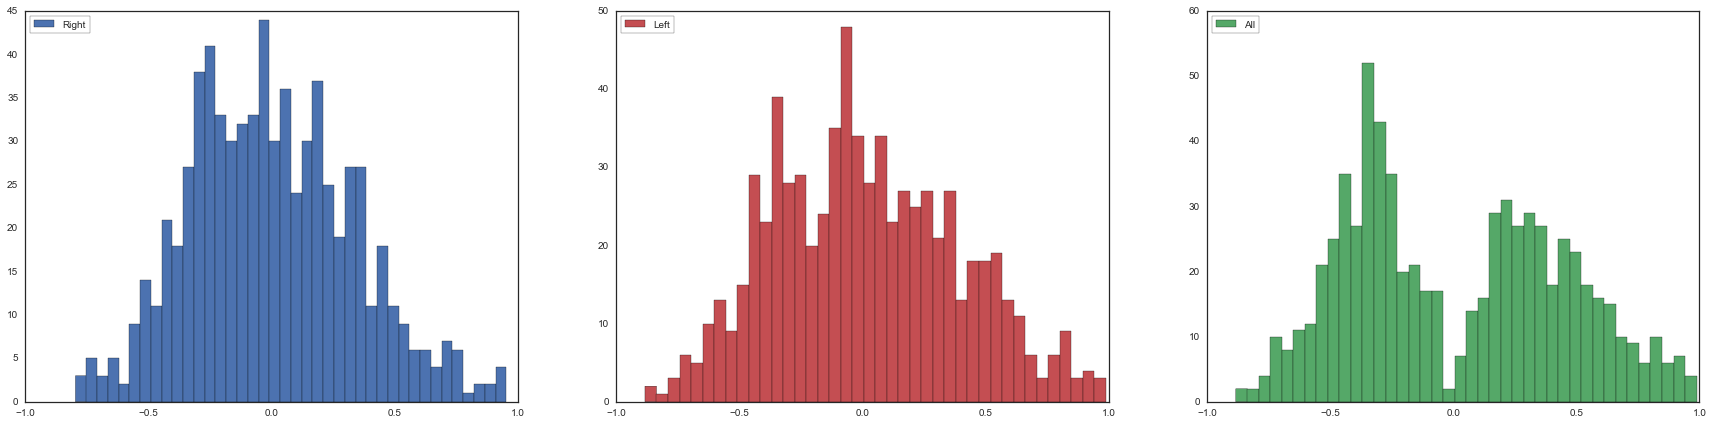

In [61]:
f,(ax,bx,cx) = pl.subplots(1,3,figsize=[30,7])
Pr = []
pR = []
pL = []
for tP in MUApeaks[:]:
    idx = np.where(LTrain.timeAxis == tP)[0][0]
    ii = idx-150
    jj = idx+150
    ti = LTrain.timeAxis[ii]
    tf = LTrain.timeAxis[jj]
    evIds = []
    for cellID in LTrain.id_list:
        spk = LTrain[cellID]
        inWindowSpikes = np.logical_and(spk.spike_times > ti,spk.spike_times < tf)
        evIds.append(spk.spike_times[inWindowSpikes].mean())
    Npcells = np.logical_not(np.isnan(evIds)).sum()
    timeSortedIds =  np.argsort(evIds)[:Npcells]
    Lsub = subsequence(timeSortedIds,leftFields)[0]
    Rsub = subsequence(timeSortedIds,rightFields)[0]
    if Lsub.size > 2:
        Lr = pearsonr(Lsub,sorted(Lsub))[0]
    else: 
        Lr = 0
    if Rsub.size > 2:
        Rr = pearsonr(Rsub,sorted(Rsub))[0]
    else:
        Rr = 0
    LRcorr = np.array([Lr,Rr])
    Pr.append(LRcorr[np.argmax(np.abs(LRcorr))])
    pR.append(Rr)
    pL.append(Lr)
ax.hist([pR],40,label=['Right'],color=sns.color_palette('deep')[0]);
bx.hist([pL],40,label=['Left'],color=sns.color_palette('deep')[2]);
cx.hist([Pr],40,label=['All'],color=sns.color_palette('deep')[1]);
ax.set_xlim([-1,1])
ax.legend(loc=2);
bx.legend(loc=2);
cx.legend(loc=2);

In [53]:
#pkl.dump(Pr,open(dataFolder+'434D1All.lro','wb'),pkl.HIGHEST_PROTOCOL)
#pkl.dump(pL,open(dataFolder+'434D1Left.lro','wb'),pkl.HIGHEST_PROTOCOL)
#pkl.dump(pR,open(dataFolder+'434D1Right.lro','wb'),pkl.HIGHEST_PROTOCOL)

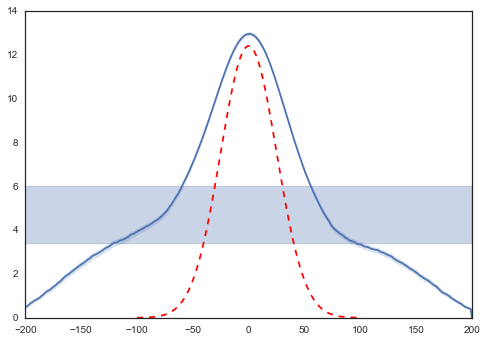

In [63]:
peakProfs = np.zeros([MUApeaks.size,400])
MUAtimes = []
for kkk,tP in enumerate(MUApeaks[:]):
    idx = np.where(LTrain.timeAxis == tP)[0][0]
    idxMin = np.argmin(np.power(MUA1[idx-200:idx]-0.6*msd,2))
    idxMAX = np.argmin(np.power(MUA1[idx:idx+200]-0.6*msd,2))
    ii = idx-200 +idxMin
    jj = idx + idxMAX
    if jj-ii > 50:
        MUAtimes.append([LTrain.timeAxis[ii],LTrain.timeAxis[jj],tP])
        peakProfs[kkk,idxMin:200+idxMAX]+=MUA1[ii:jj]
sns.tsplot(peakProfs,time=np.linspace(-200,200,400))
pl.axhspan(0.6*msd,0.6*m3sd,alpha=0.3)
pl.plot(np.linspace(-100,100,200),12.4*K1,'r--')

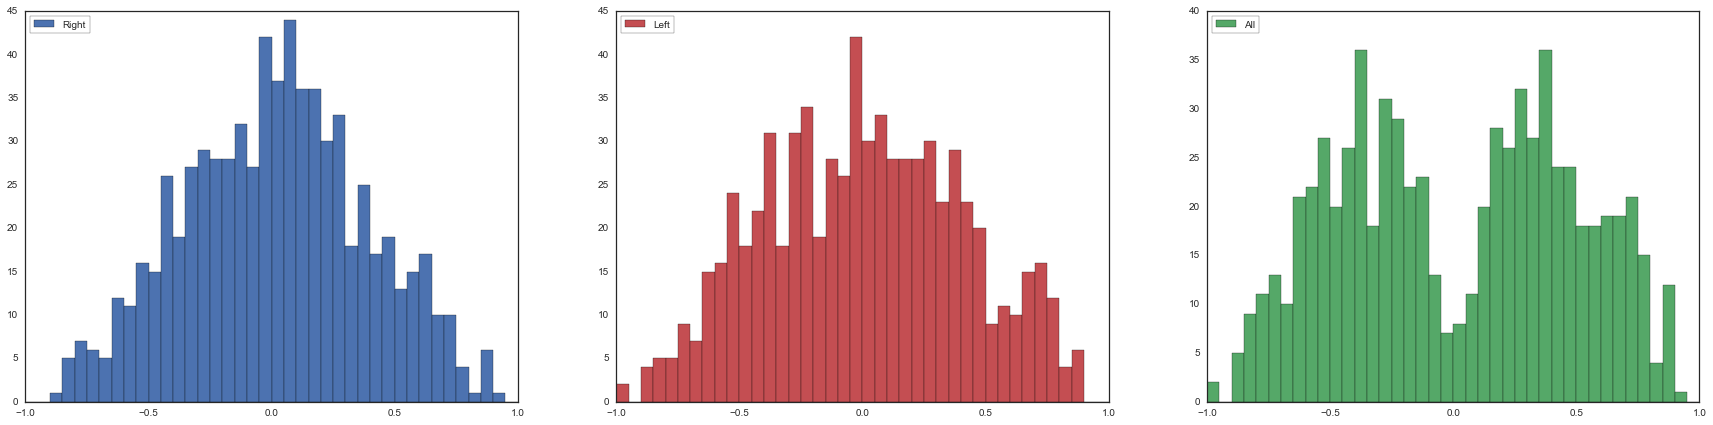

In [64]:
corrBins = np.arange(-1.05,1.15,0.05)
corrBinsCenters = (corrBins+0.025)[:-1]
f,(ax,bx,cx) = pl.subplots(1,3,figsize=[30,7],sharex=True)
Pr = []
pR = []
pL = []
fghj = np.zeros([len(MUAtimes),10])
for kkk,item in enumerate(MUAtimes):
    ti=item[0]
    tf=item[1]
    tP=item[2]
    evIds = []
    for cellID in LTrain.id_list:
        spk = LTrain[cellID]
        inWindowSpikes = np.logical_and(spk.spike_times > ti,spk.spike_times < tf)
        evIds.append(spk.spike_times[inWindowSpikes].mean())
    Npcells = np.logical_not(np.isnan(evIds)).sum()
    timeSortedIds =  np.argsort(evIds)[:Npcells]
    #print timeSortedIds.size
    Lsub = subsequence(timeSortedIds,leftFields)[0]
    Rsub = subsequence(timeSortedIds,rightFields)[0]
    if Lsub.size>3:
        Lr = pearsonr(range(Lsub.size),np.argsort(Lsub))[0]#pearsonr(Lsub,sorted(Lsub))[0]
    else: 
        Lr = 100#np.nan
    if Rsub.size>3:
        Rr = pearsonr(range(Rsub.size),np.argsort(Rsub))[0]#pearsonr(Rsub,sorted(Rsub))[0]
    else:
        Rr = 100#np.nan
    LRcorr = np.array([Lr,Rr])
    #if LRcorr.sum()<200:
        #print LRcorr, np.argsort(Rsub)
    Pr.append(LRcorr[np.argmax(np.abs(LRcorr))])
    pR.append(Rr)
    pL.append(Lr)
    fghj[kkk,:]+= np.array([ti,tf,tP,timeSortedIds.size,Lsub.size,Rsub.size,Lr,Rr,1.0,1.0])
ax.hist([pR],corrBins,label=['Right'],color=sns.color_palette('deep')[0]);
bx.hist([pL],corrBins,label=['Left'],color=sns.color_palette('deep')[2]);
cx.hist([Pr],corrBins,label=['All'],color=sns.color_palette('deep')[1]);
ax.set_xlim([-1,1])
ax.legend(loc=2);
bx.legend(loc=2);
cx.legend(loc=2);

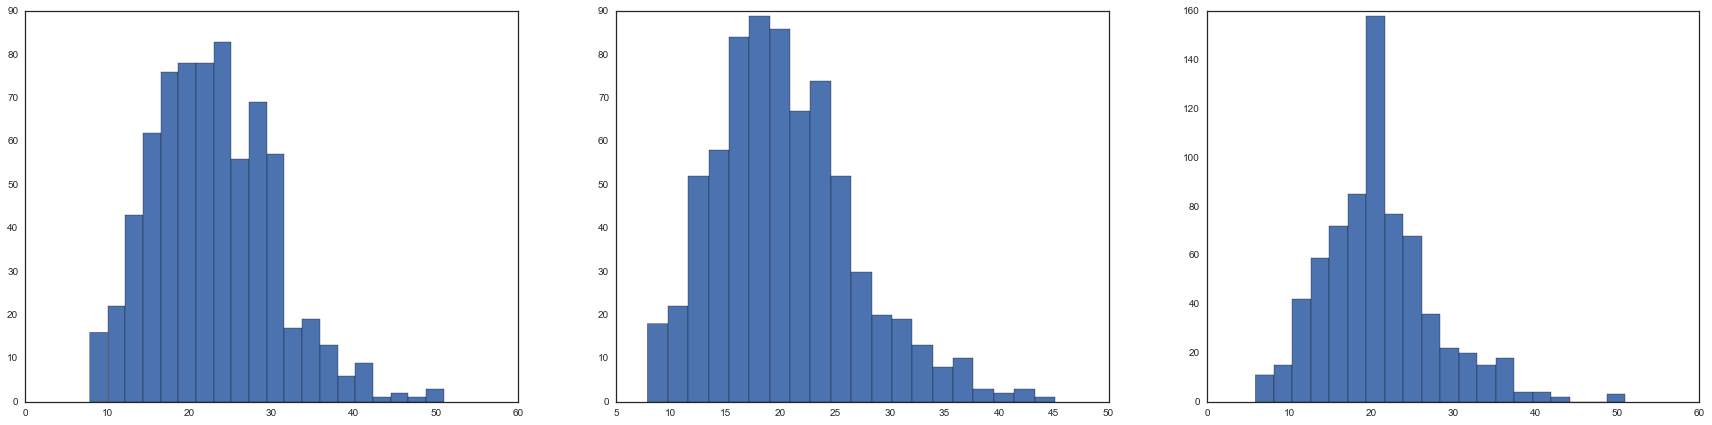

In [65]:
f,(ax,bx,cx) = pl.subplots(1,3,figsize=[30,7])
ax.hist(1e2*fghj[:,3]/LTrain.id_list.size,20);
bx.hist(1e2*fghj[:,4]/LTrain.id_list.size,20);
cx.hist(1e2*fghj[:,5]/LTrain.id_list.size,20);

In [66]:
import pandas as pd
df = pd.DataFrame(fghj,columns=['ti','tf','tp','tSub','lSub','rSub','Lcorr','Rcorr','Lpv','Rpv'])
df = df.replace(100,np.nan)
surrProbs = []
for n in range(4,10):
    crr = pkl.load(open('../../RankOrder/corr'+str(n)+'.crr','rb'))
    hst = np.histogram(crr,corrBins,normed=True)[0]
    surrProbs.append(hst)

In [67]:
for n in range(4,10):
    print n
    print '----------------'
    dfLsub = df[df.lSub==n]
    dfRsub = df[df.rSub==n]
    hstL = np.histogram(dfLsub.Lcorr,corrBins)[0]
    hstR = np.histogram(dfRsub.Rcorr,corrBins)[0]
    for item in np.where(hstL)[0]:
        #print hstL[item],corrBinsCenters[item]
        p_value = binom_test(hstL[item],hstL.sum(),surrProbs[n-4][item]*0.05)
        if p_value < 0.05:
            idxs = np.where(np.abs(findClosestPoint(dfLsub.Lcorr,corrBinsCenters)[1]- corrBinsCenters[item])<0.01)[0]
            locs = dfLsub.index[idxs]
            df.Lpv[locs] += (p_value-1)
            #print p_value,dfLsub.Lcorr.loc[locs]
    #print '####################'
    for item in np.where(hstR)[0]:
        #print hstR[item],corrBinsCenters[item]
        p_value = binom_test(hstR[item],hstR.sum(),surrProbs[n-4][item]*0.05)
        if p_value < 0.05:
            idxs = np.where(np.abs(findClosestPoint(dfRsub.Rcorr,corrBinsCenters)[1]- corrBinsCenters[item])<0.01)[0]
            locs = dfRsub.index[idxs]
            df.Rpv[locs] += (p_value-1)
            #print p_value

    print '##############################################################################'
###################################################################################
print '9++'
dfLsub = df[df.lSub>9]
dfRsub = df[df.rSub>9]
hstL = np.histogram(dfLsub.Lcorr,corrBins)[0]
hstR = np.histogram(dfRsub.Rcorr,corrBins)[0]
for item in np.where(hstL)[0]:
    #print hstL[item],corrBinsCenters[item]
    p_value = binom_test(hstL[item],hstL.sum(),surrProbs[-1][item]*0.05)
    if p_value < 0.05:
        #print corrBinsCenters[item],p_value
        idxs = np.where(np.abs(findClosestPoint(dfLsub.Lcorr,corrBinsCenters)[1]- corrBinsCenters[item])<0.01)[0]
        locs = dfLsub.index[idxs]
        df.Lpv[locs] += (p_value-1)
print '####################'
for item in np.where(hstR)[0]:
    #print hstR[item],corrBinsCenters[item]
    p_value = binom_test(hstR[item],hstR.sum(),surrProbs[-1][item]*0.05)
    if p_value < 0.05:
        idxs = np.where(np.abs(findClosestPoint(dfRsub.Rcorr,corrBinsCenters)[1]- corrBinsCenters[item])<0.01)[0]
        locs = dfRsub.index[idxs]
        df.Rpv[locs] += (p_value-1)


4
----------------
##############################################################################
5
----------------
##############################################################################
6
----------------
##############################################################################
7
----------------
##############################################################################
8
----------------
##############################################################################
9
----------------
##############################################################################
9++
####################


/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


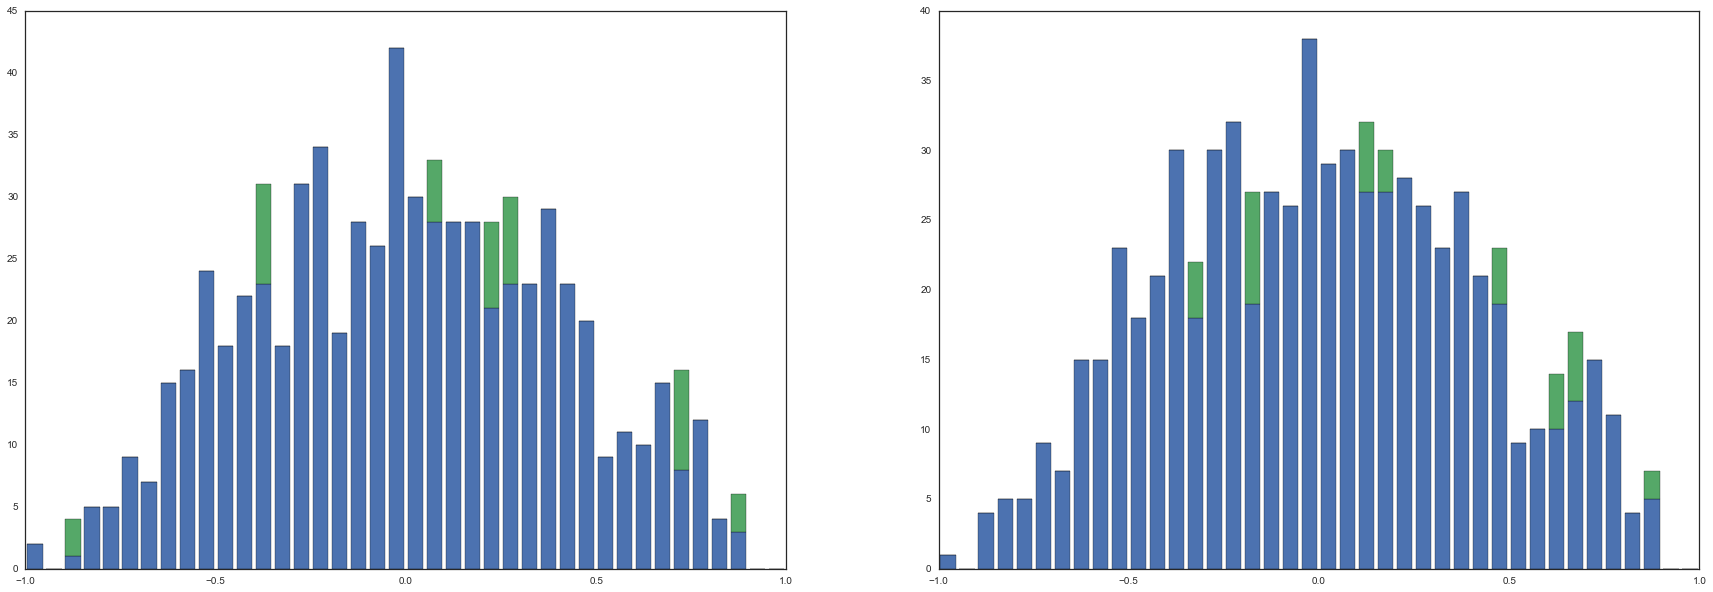

In [68]:
fig,(ax,bx) = pl.subplots(1,2,figsize=[30,10],sharex=True)
ax.hist([df[df.Lpv==1].Lcorr,df[df.Lpv!=1].Lcorr],corrBins,label=[],normed=False,stacked=True);
bx.hist([df[df.Rpv==1].Lcorr,df[df.Rpv!=1].Rcorr],corrBins,label=[],normed=False,stacked=True);
ax.set_xlim(-1,1)
pl.legend()

In [72]:
df[df.Lcorr>0.75]

,ti,tf,tp,tSub,lSub,rSub,Lcorr,Rcorr,Lpv,Rpv
7,3690057.5,3690182.5,3690124.5,7,6,7,0.828571,0.750000,1.000000,1.000000
51,3834148.5,3834451.5,3834252.5,8,6,7,0.885714,0.214286,1.000000,1.000000
58,3850191.5,3850520.5,3850391.5,10,8,10,0.857143,0.709091,1.000000,1.000000
85,3910299.5,3910537.5,3910368.5,14,12,13,0.874126,0.620879,0.025038,1.000000
86,3911633.5,3911889.5,3911808.5,13,11,13,0.863636,0.560440,0.025038,1.000000
111,3956662.5,3956858.5,3956749.5,12,11,12,0.754545,0.440559,1.000000,1.000000
116,3967564.5,3967734.5,3967655.5,16,15,16,0.835714,0.735294,1.000000,1.000000
151,4051104.5,4051263.5,4051180.5,11,10,10,0.854545,0.757576,0.025038,1.000000
207,4156346.5,4156575.5,4156430.5,12,11,11,0.754545,0.663636,1.000000,1.000000
224,4188460.5,4188744.5,4188558.5,9,8,9,0.809524,0.183333,1.000000,1.000000


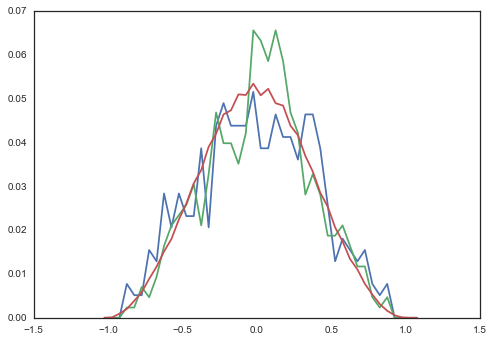

In [83]:
pl.plot(corrBinsCenters,1.*hstL/hstL.sum())
pl.plot(corrBinsCenters,1.*hstR/hstR.sum())
pl.plot(corrBinsCenters,5e-2*surrProbs[-1])